<a href="https://colab.research.google.com/github/SMunira38/RPDC_withVGG19_30ep/blob/main/RiceLeafDiseases_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:

import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import vgg19
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [15]:
!pip install scikit-learn numpy

In [16]:


# Set random seed for reproducibility
torch.manual_seed(42)


In [17]:


# Define paths for the dataset
data_dir = '/content/drive/MyDrive/RiceLeafsDisease'
batch_size = 32

In [18]:

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:

# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [20]:

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
print("Total images:", len(dataset))
print("Train images:", train_size)
print("Validation images:", val_size)
print("Test images:", test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

Total images: 2091
Train images: 1463
Validation images: 313
Test images: 315


In [21]:

# Create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


num_classes = len(dataset.classes)
print("Number of classes: ", num_classes)

Number of classes:  6


In [22]:

# Load the pre-trained VGG19 model and modify it for your classification task

model = vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 266MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Train the model
# Training loop
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy*100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy*100:.2f}%")

print("Finished Training")

Epoch [1/30] - Train Loss: 0.898458 - Train Acc: 64.25% - Val Loss: 0.425302 - Val Acc: 84.98%
Epoch [2/30] - Train Loss: 0.292676 - Train Acc: 89.54% - Val Loss: 0.146264 - Val Acc: 95.21%
Epoch [3/30] - Train Loss: 0.118907 - Train Acc: 95.35% - Val Loss: 0.172378 - Val Acc: 92.97%
Epoch [4/30] - Train Loss: 0.144032 - Train Acc: 95.42% - Val Loss: 0.088144 - Val Acc: 95.53%
Epoch [5/30] - Train Loss: 0.069612 - Train Acc: 97.74% - Val Loss: 0.055443 - Val Acc: 97.44%
Epoch [6/30] - Train Loss: 0.037972 - Train Acc: 98.50% - Val Loss: 0.049745 - Val Acc: 97.76%
Epoch [7/30] - Train Loss: 0.015692 - Train Acc: 99.38% - Val Loss: 0.062521 - Val Acc: 96.49%
Epoch [8/30] - Train Loss: 0.040592 - Train Acc: 98.70% - Val Loss: 0.056128 - Val Acc: 97.44%
Epoch [9/30] - Train Loss: 0.036814 - Train Acc: 98.70% - Val Loss: 0.140826 - Val Acc: 95.21%
Epoch [10/30] - Train Loss: 0.068340 - Train Acc: 97.88% - Val Loss: 0.186511 - Val Acc: 94.25%
Epoch [11/30] - Train Loss: 0.029187 - Train Acc:

In [25]:
# Testing loop
test_accuracies = []

model.eval()
correct_predictions_test = 0
total_samples_test = 0

class_correct = [0] * len(train_dataset.dataset.classes)  # Use train_dataset.dataset.classes
class_total = [0] * len(train_dataset.dataset.classes)    # Use train_dataset.dataset.classes

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store predicted and actual labels
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

        # Calculate correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

print(f"Total Correct Predictions on Test Set: {correct_predictions_test} out of {total_samples_test} samples")


Testing Accuracy: 96.51%
Total Correct Predictions on Test Set: 304 out of 315 samples


In [26]:

!pip install tabulate


In [27]:

from tabulate import tabulate
# Print predicted and actual labels in a table
table_data = []
for i in range(len(predicted_labels)):
    table_data.append([i + 1, test_dataset.dataset.classes[predicted_labels[i]], test_dataset.dataset.classes[actual_labels[i]]])

table_headers = ["Sample", "Predicted Label", "Actual Label"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------+-----------------------+-----------------------+
|   Sample | Predicted Label       | Actual Label          |
+==========+=======================+=======================+
|        1 | Leaf Blast            | Leaf Blast            |
+----------+-----------------------+-----------------------+
|        2 | Brown Spot            | Brown Spot            |
+----------+-----------------------+-----------------------+
|        3 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        4 | Leaf Blast            | Leaf Blast            |
+----------+-----------------------+-----------------------+
|        5 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        6 | Leaf Blast            | Leaf Blast            |
+----------+-----------------------+-----------------------+
|        7 | Leaf Blast            | Brown Spot            |
+----------+------------

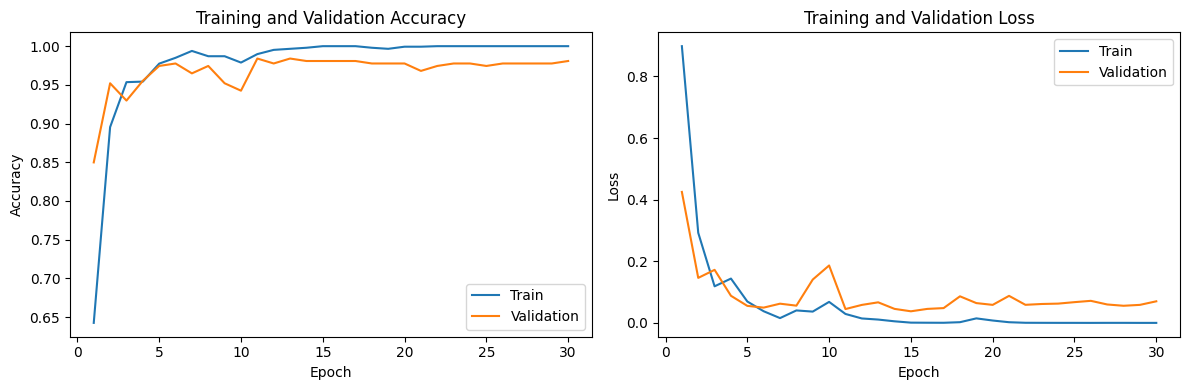

In [28]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='weighted')

# Create a table with weighted precision, recall, and F1-score
weighted_metrics = [["Weighted", precision, recall, f1]]

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(weighted_metrics, headers=table_headers, tablefmt="grid"))


# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Weighted |    0.966016 | 0.965079 |   0.965083 |
+----------+-------------+----------+------------+

Confusion Matrix:
[[65  0  0  0  0  0]
 [ 1 64  1  1  0  0]
 [ 0  0 34  0  0  0]
 [ 0  4  1 66  0  0]
 [ 0  0  0  0 35  0]
 [ 0  2  0  1  0 40]]


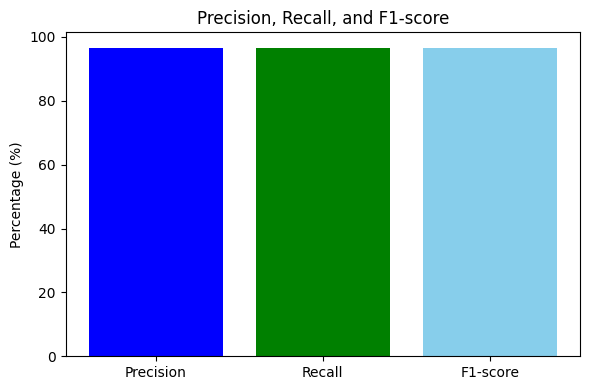

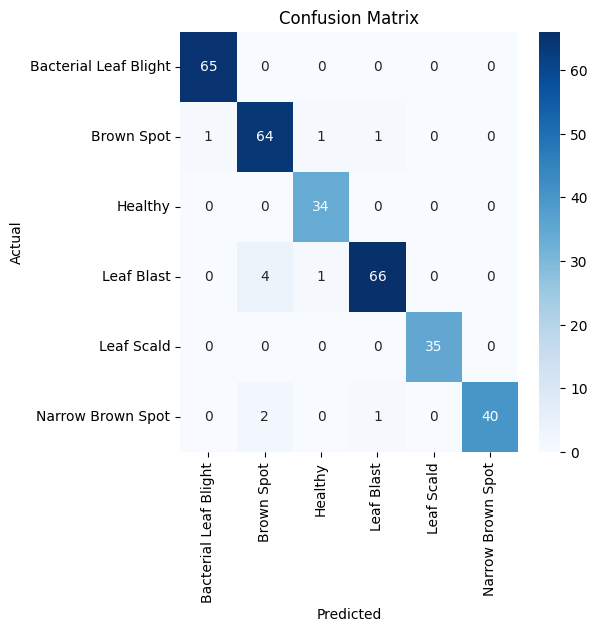

In [30]:

precision_percent = precision * 100
recall_percent = recall * 100
f1_percent = f1 * 100

metrics = ['Precision', 'Recall', 'F1-score']
values = [precision_percent, recall_percent, f1_percent]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'green', 'skyblue'])
plt.ylabel('Percentage (%)')
plt.title('Precision, Recall, and F1-score')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:

table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    accuracy = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0
    table_data.append([class_name, class_correct[i], class_total[i], f"{accuracy:.2f}%"])

table_headers = ["Class", "Correct", "Total", "Accuracy"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))


+-----------------------+-----------+---------+------------+
| Class                 |   Correct |   Total | Accuracy   |
+=======================+===========+=========+============+
| Bacterial Leaf Blight |        65 |      65 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Brown Spot            |        64 |      67 | 95.52%     |
+-----------------------+-----------+---------+------------+
| Healthy               |        34 |      34 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Leaf Blast            |        66 |      71 | 92.96%     |
+-----------------------+-----------+---------+------------+
| Leaf Scald            |        35 |      35 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Narrow Brown Spot     |        40 |      43 | 93.02%     |
+-----------------------+-----------+---------+------------+


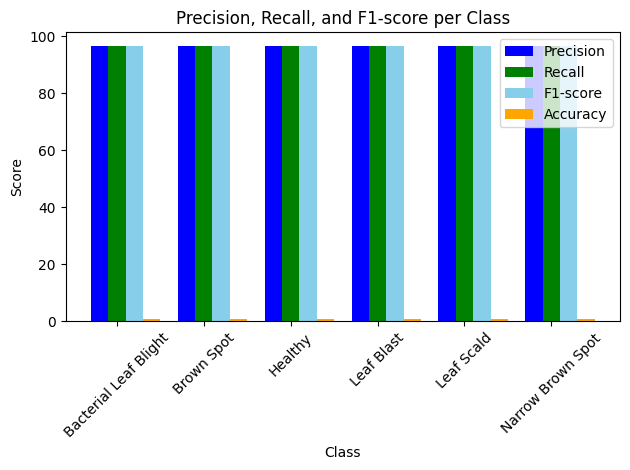

In [33]:
# Plot precision, recall, and F1-score
x = np.arange(len(test_dataset.dataset.classes))
width = 0.2

plt.bar(x - width, precision_percent, width, label='Precision', color='blue')
plt.bar(x, recall_percent, width, label='Recall', color='green')
plt.bar(x + width, f1_percent, width, label='F1-score', color='skyblue')
plt.bar(x +2 * width,accuracy/100, width, label='Accuracy', color='orange')


plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(x, test_dataset.dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()